<a href="https://colab.research.google.com/github/moraljack/stock/blob/main/line_%E9%80%9A%E7%9F%A5%E8%B2%B7%E8%82%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#每次都要安裝 talib

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
#!./configure --prefix=/usr/local
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

import numpy as np
import pandas as pd
import talib
from talib import MA_Type
from talib import abstract

--2023-11-28 01:06:24--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-11-28 01:06:24--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://netix.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-11-28 01:06:25--  http://netix.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving netix.dl.sourceforg

#選股策略

In [6]:
import os,sys
import requests
import datetime
import matplotlib
import matplotlib.pyplot as plt
def reportip3_stock():

    now_hour=int(str(datetime.datetime.strptime(str(datetime.datetime.utcnow()+datetime.timedelta(hours=+8))[:19], '%Y-%m-%d %H:%M:%S'))[11:13])

    target_list=["8436","0050","2636","8027","2031","2497","3034","2597"]

    #####################################################################################################################下載歷史資料#######################################################################################
    url = "https://api.finmindtrade.com/api/v4/data"
    for i in range(len(target_list)):
        print("i=",i)
        parameter = {
            "dataset": "TaiwanStockPrice",
            "data_id": target_list[i],
            "start_date": "2020-01-01",
            "token": "", # 參考登入，獲取金鑰
        }
        resp = requests.get(url, params=parameter)
        data = resp.json()
        if i==0:
            df_ETF = pd.DataFrame(data["data"])
            df_ETF["date"] = pd.DataFrame(data["data"])["date"]
        df_ETF[target_list[i]] = pd.DataFrame(data["data"])["close"]
    df_ETF.to_csv('df_ETF.csv', encoding = 'utf-8')
    df_ETF=pd.read_csv('df_ETF.csv', encoding = "utf-8")

    df_ETF = df_ETF[["date",target_list[0],target_list[1],target_list[2],target_list[3],target_list[4],target_list[5],target_list[6],target_list[7] ]]

    trade=[0]*len(target_list)
    trade_already=[0]*len(target_list)
    trade_price=[0]*len(target_list)
    total_GetMoney=[0]*len(target_list)

    trade_amount=0
    total_time=0
    win_time=0
    the_cost=-40

    for i in range(len(target_list)):
        close = np.array(df_ETF[target_list[i]], dtype=float)
        print("target_list[i]=",target_list[i])
        df_ETF[target_list[i]] = df_ETF[target_list[i]]
        SMA_7 = talib.SMA(close,9) #close 代進WMA方法做計算
        SMA_20 = talib.SMA(close,28) #close 代進SMA方法做計算
        df_ETF[target_list[i]+'_SMA_7'] = SMA_7
        df_ETF[target_list[i]+'_SMA_20'] = SMA_20
        df_ETF[target_list[i]+'_多空交易'] = ''
        df_ETF[target_list[i]+'_持倉'] = 0
        df_ETF[target_list[i]+'_該筆交易損益'] = 0
        df_ETF[target_list[i]+'_交易損益'] = 0

    df_ETF['總交易損益'] = 0
    trade_amount=1/len(target_list)

    for i in range(0,len(df_ETF.index)):
        if np.isnan( df_ETF[target_list[0]+'_SMA_20'].iloc[i]) == False:
            trade_day=str(df_ETF['date'].iloc[i])[:10]

            for j in range(len(target_list)):
                ##################################################################################################主策略###############################################################################################
                if trade[j]==0:

                    if df_ETF[target_list[j]].iloc[i] >= df_ETF[target_list[j]+'_SMA_7'].iloc[i] and df_ETF[target_list[j]].iloc[i] >= df_ETF[target_list[j]+'_SMA_20'].iloc[i]:
                        trade[j]=1
                        trade_price[j]=df_ETF[target_list[j]].iloc[i]
                        df_ETF[target_list[j]+'_持倉'].iloc[i]=trade_amount
                        df_ETF[target_list[j]+'_多空交易'].iloc[i]='做多@'+str(trade_price[j])

                        trade_day=datetime.datetime.strptime(str(df_ETF['date'].iloc[i])[:10], '%Y-%m-%d')
                        data_list_tradeday=[]
                        data_list_tradeday.append(trade_day)
                elif trade[j]==1:
                    if df_ETF[target_list[j]].iloc[i] <= df_ETF[target_list[j]+'_SMA_7'].iloc[i] or df_ETF[target_list[j]].iloc[i] <= df_ETF[target_list[j]+'_SMA_20'].iloc[i]:
                        trade[j]=0

                        if (df_ETF[target_list[j]].iloc[i] - trade_price[j]) >= 0:
                            df_ETF[target_list[j]+'_多空交易'].iloc[i]='賺錢@'+str(df_ETF[target_list[j]].iloc[i])
                            win_time = win_time+1
                        else:
                            df_ETF[target_list[j]+'_多空交易'].iloc[i]='賠錢@'+str(df_ETF[target_list[j]].iloc[i])

                        #百分比算法=(原本成交價-平倉價)/平倉價*amount
                        df_ETF[target_list[j]+'_該筆交易損益'].iloc[i]=100*(df_ETF[target_list[j]].iloc[i]-trade_price[j])/trade_price[j]*df_ETF[target_list[j]+'_持倉'].iloc[i-1]
                        total_GetMoney[j]=total_GetMoney[j]+df_ETF[target_list[j]+'_該筆交易損益'].iloc[i]
                        total_time=total_time+1
                        #print('total_GetMoney'+str(total_GetMoney))
                    else:
                        df_ETF[target_list[j]+'_持倉'].iloc[i]=trade_amount


                df_ETF[target_list[j]+'_交易損益'].iloc[i] = total_GetMoney[j]

                trade_already = trade.copy()
                df_ETF['總交易損益'].iloc[i]=0
                for j in range(len(target_list)):
                    df_ETF['總交易損益'].iloc[i]=df_ETF['總交易損益'].iloc[i]+df_ETF[target_list[j]+'_交易損益'].iloc[i]

    #####################################################################################################################畫圖#######################################################################################
    fig = plt.figure()
    ax1 = fig.add_subplot(211, ylabel=target_list[j]+'_交易損益')
    df_ETF[target_list[j]+'_交易損益'].plot(ax=ax1, color='red', figsize=(5,4))
    ax3 = fig.add_subplot(212, ylabel="df_ETF['總交易損益']")
    df_ETF['總交易損益'].plot(ax=ax3, color='gray', figsize=(10,8))
    fig.savefig('./stock2.png')
    from IPython.display import Image
    Image('./stock2.png')



    data_list=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    data_list[0]=target_list[0]
    data_list[1]=str(100*df_ETF[target_list[0]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[2]=target_list[1]
    data_list[3]=str(100*df_ETF[target_list[1]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[4]=target_list[2]
    data_list[5]=str(100*df_ETF[target_list[2]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[6]=target_list[3]
    data_list[7]=str(100*df_ETF[target_list[3]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[8]=target_list[4]
    data_list[9]=str(100*df_ETF[target_list[4]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[10]=target_list[5]
    data_list[11]=str(100*df_ETF[target_list[5]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[12]=target_list[6]
    data_list[13]=str(100*df_ETF[target_list[6]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[14]=target_list[7]
    data_list[15]=str(100*df_ETF[target_list[7]+'_持倉'].iloc[len(df_ETF)-1])[:4]

    print("data_list:",data_list)
    text=("\n投組1：" + str(data_list[0]) + '持倉：' + str("空手" if df_ETF[target_list[0]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組2：" + str(data_list[2]) + '持倉：' + str("空手" if df_ETF[target_list[1]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組3：" + str(data_list[4]) + '持倉：' + str("空手" if df_ETF[target_list[2]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組4：" + str(data_list[6]) + '持倉：' + str("空手" if df_ETF[target_list[3]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組5：" + str(data_list[8]) + '持倉：' + str("空手" if df_ETF[target_list[4]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組6：" + str(data_list[10]) + '持倉：' + str("空手" if df_ETF[target_list[5]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組7：" + str(data_list[12]) + '持倉：' + str("空手" if df_ETF[target_list[6]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組8：" + str(data_list[14]) + '持倉：' + str("空手" if df_ETF[target_list[7]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\nETF總交易損益=" + str(round(df_ETF['總交易損益'].iloc[-1])) + '%' +
          "\nhttps://yangreform.com/ETF/" )
    print(text)
    for i in range(0,len(target_list)):
        print(df_ETF[[target_list[i],target_list[i]+'_持倉',target_list[i]+'_交易損益']].tail(3))


    #line_send_text(text)
    return text

reportip3_stock()

i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
target_list[i]= 8436
target_list[i]= 0050
target_list[i]= 2636
target_list[i]= 8027
target_list[i]= 2031
target_list[i]= 2497
target_list[i]= 3034
target_list[i]= 2597


<ipython-input-6-234f12ff2d8c>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF[target_list[j]+'_交易損益'].iloc[i] = total_GetMoney[j]
<ipython-input-6-234f12ff2d8c>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF['總交易損益'].iloc[i]=0
<ipython-input-6-234f12ff2d8c>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF['總交易損益'].iloc[i]=df_ETF['總交易損益'].iloc[i]+df_ETF[target_list[j]+'_交易損益'].iloc[i]
<ipython-input-6-234f12

data_list: ['8436', '0.0', '0050', '0.0', '2636', '0.0', '8027', '12.5', '2031', '0.0', '2497', '0.0', '3034', '12.5', '2597', '12.5', 16, 17, 18, 19]

投組1：8436持倉：空手
投組2：0050持倉：空手
投組3：2636持倉：空手
投組4：8027持倉：買進
投組5：2031持倉：空手
投組6：2497持倉：空手
投組7：3034持倉：買進
投組8：2597持倉：買進
ETF總交易損益=136%
https://yangreform.com/ETF/
      8436  8436_持倉  8436_交易損益
947  174.0    0.125   5.685073
948  173.0    0.000   5.613234
949  173.5    0.000   5.613234
       0050  0050_持倉  0050_交易損益
947  131.30    0.125   5.912476
948  131.20    0.125   5.912476
949  130.35    0.000   6.499826
     2636  2636_持倉  2636_交易損益
947  75.9      0.0  45.200058
948  75.8      0.0  45.200058
949  76.1      0.0  45.200058
     8027  8027_持倉  8027_交易損益
947  67.7    0.125  10.498848
948  69.5    0.125  10.498848
949  68.0    0.125  10.498848
      2031  2031_持倉  2031_交易損益
947  48.90    0.125  15.791529
948  48.75    0.125  15.791529
949  48.35    0.000  15.908961
     2497  2497_持倉  2497_交易損益
947  67.4    0.125  23.378923
948  66.1    0.125

<ipython-input-6-234f12ff2d8c>:108: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-6-234f12ff2d8c>:108: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-6-234f12ff2d8c>:108: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-6-234f12ff2d8c>:108: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-6-234f12ff2d8c>:108: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  fig.savefig('./stock2.png')


'\n投組1：8436持倉：空手\n投組2：0050持倉：空手\n投組3：2636持倉：空手\n投組4：8027持倉：買進\n投組5：2031持倉：空手\n投組6：2497持倉：空手\n投組7：3034持倉：買進\n投組8：2597持倉：買進\nETF總交易損益=136%\nhttps://yangreform.com/ETF/'

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRA

##實作1：把自己有買的股票填進去

i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
target_list[i]= 1905
target_list[i]= 2363
target_list[i]= 2707
target_list[i]= 2731
target_list[i]= 3231
target_list[i]= 3706
target_list[i]= 4961
target_list[i]= 4968


<ipython-input-7-2b80a8948dc3>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF[target_list[j]+'_持倉'].iloc[i]=trade_amount
<ipython-input-7-2b80a8948dc3>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF[target_list[j]+'_多空交易'].iloc[i]='做多@'+str(trade_price[j])
<ipython-input-7-2b80a8948dc3>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF[target_list[j]+'_交易損益'].iloc[i] = total_GetMoney[j]
<ipython-input-7-2b80a

data_list: ['1905', '0.0', '2363', '0.0', '2707', '0.0', '2731', '0.0', '3231', '0.0', '3706', '0.0', '4961', '12.5', '4968', '12.5', 16, 17, 18, 19]

投組1：1905持倉：空手
投組2：2363持倉：空手
投組3：2707持倉：空手
投組4：2731持倉：空手
投組5：3231持倉：空手
投組6：3706持倉：空手
投組7：4961持倉：買進
投組8：4968持倉：買進
總交易損益=145%
      1905  1905_持倉  1905_交易損益
947  21.85    0.125  14.399164
948  21.70    0.125  14.399164
949  21.70    0.000  14.399164
      2363  2363_持倉  2363_交易損益
947  48.25      0.0  21.225749
948  47.00      0.0  21.225749
949  46.10      0.0  21.225749
      2707  2707_持倉  2707_交易損益
947  231.5    0.125   4.422700
948  221.0    0.000   5.077462
949  216.5    0.000   5.077462
      2731  2731_持倉  2731_交易損益
947  145.0    0.125   9.929142
948  138.0    0.000   9.492079
949  138.5    0.000   9.492079
     3231  3231_持倉  3231_交易損益
947  95.1      0.0  21.164959
948  96.0      0.0  21.164959
949  92.7      0.0  21.164959
      3706  3706_持倉  3706_交易損益
947  40.90    0.125   3.682921
948  39.75    0.000   3.826051
949  38.25    0.0

<ipython-input-7-2b80a8948dc3>:106: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-7-2b80a8948dc3>:106: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-7-2b80a8948dc3>:106: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-7-2b80a8948dc3>:106: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-7-2b80a8948dc3>:106: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  fig.savefig('./stock2.png')


'\n投組1：1905持倉：空手\n投組2：2363持倉：空手\n投組3：2707持倉：空手\n投組4：2731持倉：空手\n投組5：3231持倉：空手\n投組6：3706持倉：空手\n投組7：4961持倉：買進\n投組8：4968持倉：買進\n總交易損益=145%'

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRA

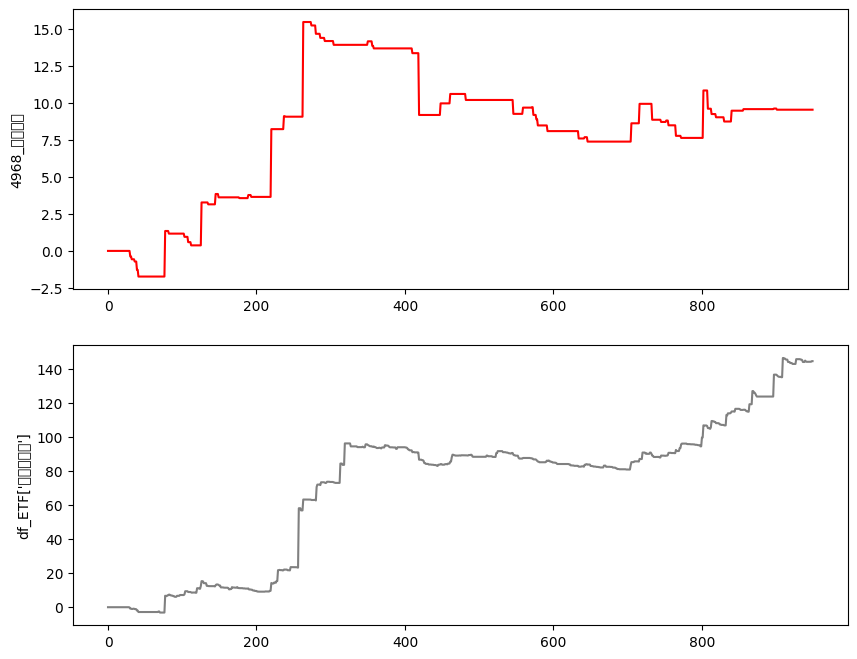

In [7]:
import os,sys
import requests

def reportip3_stock():

    now_hour=int(str(datetime.datetime.strptime(str(datetime.datetime.utcnow()+datetime.timedelta(hours=+8))[:19], '%Y-%m-%d %H:%M:%S'))[11:13])

    target_list=["1905","2363","2707","2731","3231","3706","4961","4968"]

    #####################################################################################################################下載歷史資料#######################################################################################
    url = "https://api.finmindtrade.com/api/v4/data"
    for i in range(len(target_list)):
        print("i=",i)
        parameter = {
            "dataset": "TaiwanStockPrice",
            "data_id": target_list[i],
            "start_date": "2020-01-01",
            "token": "", # 參考登入，獲取金鑰
        }
        resp = requests.get(url, params=parameter)
        data = resp.json()
        if i==0:
            df_ETF = pd.DataFrame(data["data"])
            df_ETF["date"] = pd.DataFrame(data["data"])["date"]
        df_ETF[target_list[i]] = pd.DataFrame(data["data"])["close"]
    df_ETF.to_csv('df_ETF.csv', encoding = 'utf-8')
    df_ETF=pd.read_csv('df_ETF.csv', encoding = "utf-8")

    df_ETF = df_ETF[["date",target_list[0],target_list[1],target_list[2],target_list[3],target_list[4],target_list[5],target_list[6],target_list[7] ]]

    trade=[0]*len(target_list)
    trade_already=[0]*len(target_list)
    trade_price=[0]*len(target_list)
    total_GetMoney=[0]*len(target_list)

    trade_amount=0
    total_time=0
    win_time=0
    the_cost=-40

    for i in range(len(target_list)):
        close = np.array(df_ETF[target_list[i]], dtype=float)
        print("target_list[i]=",target_list[i])
        df_ETF[target_list[i]] = df_ETF[target_list[i]]
        SMA_7 = talib.SMA(close,9) #close 代進WMA方法做計算
        SMA_20 = talib.SMA(close,28) #close 代進SMA方法做計算
        df_ETF[target_list[i]+'_SMA_7'] = SMA_7
        df_ETF[target_list[i]+'_SMA_20'] = SMA_20
        df_ETF[target_list[i]+'_多空交易'] = ''
        df_ETF[target_list[i]+'_持倉'] = 0
        df_ETF[target_list[i]+'_該筆交易損益'] = 0
        df_ETF[target_list[i]+'_交易損益'] = 0

    df_ETF['總交易損益'] = 0
    trade_amount=1/len(target_list)

    for i in range(0,len(df_ETF.index)):
        if np.isnan( df_ETF[target_list[0]+'_SMA_20'].iloc[i]) == False:
            trade_day=str(df_ETF['date'].iloc[i])[:10]

            for j in range(len(target_list)):
                ##################################################################################################主策略###############################################################################################
                if trade[j]==0:

                    if df_ETF[target_list[j]].iloc[i] >= df_ETF[target_list[j]+'_SMA_7'].iloc[i] and df_ETF[target_list[j]].iloc[i] >= df_ETF[target_list[j]+'_SMA_20'].iloc[i]:
                        trade[j]=1
                        trade_price[j]=df_ETF[target_list[j]].iloc[i]
                        df_ETF[target_list[j]+'_持倉'].iloc[i]=trade_amount
                        df_ETF[target_list[j]+'_多空交易'].iloc[i]='做多@'+str(trade_price[j])

                        trade_day=datetime.datetime.strptime(str(df_ETF['date'].iloc[i])[:10], '%Y-%m-%d')
                        data_list_tradeday=[]
                        data_list_tradeday.append(trade_day)
                elif trade[j]==1:
                    if df_ETF[target_list[j]].iloc[i] <= df_ETF[target_list[j]+'_SMA_7'].iloc[i] or df_ETF[target_list[j]].iloc[i] <= df_ETF[target_list[j]+'_SMA_20'].iloc[i]:
                        trade[j]=0

                        if (df_ETF[target_list[j]].iloc[i] - trade_price[j]) >= 0:
                            df_ETF[target_list[j]+'_多空交易'].iloc[i]='賺錢@'+str(df_ETF[target_list[j]].iloc[i])
                            win_time = win_time+1
                        else:
                            df_ETF[target_list[j]+'_多空交易'].iloc[i]='賠錢@'+str(df_ETF[target_list[j]].iloc[i])

                        #百分比算法=(原本成交價-平倉價)/平倉價*amount
                        df_ETF[target_list[j]+'_該筆交易損益'].iloc[i]=100*(df_ETF[target_list[j]].iloc[i]-trade_price[j])/trade_price[j]*df_ETF[target_list[j]+'_持倉'].iloc[i-1]
                        total_GetMoney[j]=total_GetMoney[j]+df_ETF[target_list[j]+'_該筆交易損益'].iloc[i]
                        total_time=total_time+1
                        #print('total_GetMoney'+str(total_GetMoney))
                    else:
                        df_ETF[target_list[j]+'_持倉'].iloc[i]=trade_amount


                df_ETF[target_list[j]+'_交易損益'].iloc[i] = total_GetMoney[j]

                trade_already = trade.copy()
                df_ETF['總交易損益'].iloc[i]=0
                for j in range(len(target_list)):
                    df_ETF['總交易損益'].iloc[i]=df_ETF['總交易損益'].iloc[i]+df_ETF[target_list[j]+'_交易損益'].iloc[i]

    #####################################################################################################################畫圖#######################################################################################
    fig = plt.figure()
    ax1 = fig.add_subplot(211, ylabel=target_list[j]+'_交易損益')
    df_ETF[target_list[j]+'_交易損益'].plot(ax=ax1, color='red', figsize=(5,4))
    ax3 = fig.add_subplot(212, ylabel="df_ETF['總交易損益']")
    df_ETF['總交易損益'].plot(ax=ax3, color='gray', figsize=(10,8))
    fig.savefig('./stock2.png')
    from IPython.display import Image
    Image('./stock2.png')



    data_list=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    data_list[0]=target_list[0]
    data_list[1]=str(100*df_ETF[target_list[0]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[2]=target_list[1]
    data_list[3]=str(100*df_ETF[target_list[1]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[4]=target_list[2]
    data_list[5]=str(100*df_ETF[target_list[2]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[6]=target_list[3]
    data_list[7]=str(100*df_ETF[target_list[3]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[8]=target_list[4]
    data_list[9]=str(100*df_ETF[target_list[4]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[10]=target_list[5]
    data_list[11]=str(100*df_ETF[target_list[5]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[12]=target_list[6]
    data_list[13]=str(100*df_ETF[target_list[6]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[14]=target_list[7]
    data_list[15]=str(100*df_ETF[target_list[7]+'_持倉'].iloc[len(df_ETF)-1])[:4]

    print("data_list:",data_list)
    text=("\n投組1：" + str(data_list[0]) + '持倉：' + str("空手" if df_ETF[target_list[0]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組2：" + str(data_list[2]) + '持倉：' + str("空手" if df_ETF[target_list[1]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組3：" + str(data_list[4]) + '持倉：' + str("空手" if df_ETF[target_list[2]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組4：" + str(data_list[6]) + '持倉：' + str("空手" if df_ETF[target_list[3]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組5：" + str(data_list[8]) + '持倉：' + str("空手" if df_ETF[target_list[4]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組6：" + str(data_list[10]) + '持倉：' + str("空手" if df_ETF[target_list[5]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組7：" + str(data_list[12]) + '持倉：' + str("空手" if df_ETF[target_list[6]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組8：" + str(data_list[14]) + '持倉：' + str("空手" if df_ETF[target_list[7]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n總交易損益=" + str(round(df_ETF['總交易損益'].iloc[-1])) + '%'  )
    print(text)
    for i in range(0,len(target_list)):
        print(df_ETF[[target_list[i],target_list[i]+'_持倉',target_list[i]+'_交易損益']].tail(3))


    #line_send_text(text)
    return text

reportip3_stock()

##實作2：把自己有買的股票填進去

i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
target_list[i]= 6669
target_list[i]= 3545
target_list[i]= 00679B
target_list[i]= 2743
target_list[i]= 5274
target_list[i]= 6732
target_list[i]= 8054
target_list[i]= 3661


<ipython-input-8-cca914c2f1b6>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF[target_list[j]+'_持倉'].iloc[i]=trade_amount
<ipython-input-8-cca914c2f1b6>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF[target_list[j]+'_多空交易'].iloc[i]='做多@'+str(trade_price[j])
<ipython-input-8-cca914c2f1b6>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ETF[target_list[j]+'_交易損益'].iloc[i] = total_GetMoney[j]
<ipython-input-8-cca91

data_list: ['6669', '0.0', '3545', '12.5', '00679B', '0.0', '2743', '0.0', '5274', '0.0', '6732', '0.0', '8054', '12.5', '3661', '0.0', 16, 17, 18, 19]

投組1：6669持倉：空手
投組2：3545持倉：買進
投組3：00679B持倉：空手
投組4：2743持倉：空手
投組5：5274持倉：空手
投組6：6732持倉：空手
投組7：8054持倉：買進
投組8：3661持倉：空手
總交易損益=85%
       6669  6669_持倉  6669_交易損益
947  1785.0      0.0  -1.076466
948  1750.0      0.0  -1.076466
949  1690.0      0.0  -1.076466
     3545  3545_持倉  3545_交易損益
947   NaN    0.125  17.533816
948   NaN    0.125  17.533816
949   NaN    0.125  17.533816
     00679B  00679B_持倉  00679B_交易損益
947   28.69      0.125    -1.522518
948   28.52      0.000    -1.596586
949   28.35      0.000    -1.596586
     2743  2743_持倉  2743_交易損益
947   NaN      0.0  40.841113
948   NaN      0.0  40.841113
949   NaN      0.0  40.841113
       5274  5274_持倉  5274_交易損益
947  2835.0      0.0  -5.601972
948  2820.0      0.0  -5.601972
949  2800.0      0.0  -5.601972
     6732  6732_持倉  6732_交易損益
947   NaN      0.0  -0.541887
948   NaN      0.0  -0.

<ipython-input-8-cca914c2f1b6>:106: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-8-cca914c2f1b6>:106: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-8-cca914c2f1b6>:106: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-8-cca914c2f1b6>:106: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  fig.savefig('./stock2.png')
<ipython-input-8-cca914c2f1b6>:106: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  fig.savefig('./stock2.png')


'\n投組1：6669持倉：空手\n投組2：3545持倉：買進\n投組3：00679B持倉：空手\n投組4：2743持倉：空手\n投組5：5274持倉：空手\n投組6：6732持倉：空手\n投組7：8054持倉：買進\n投組8：3661持倉：空手\n總交易損益=85%'

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRA

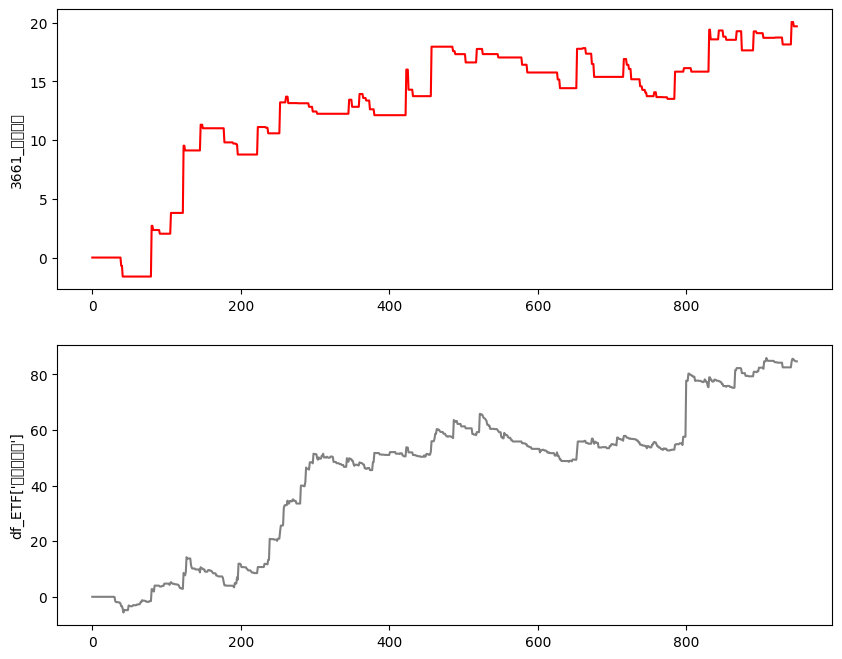

In [8]:
import os,sys
import requests

def reportip3_stock():

    now_hour=int(str(datetime.datetime.strptime(str(datetime.datetime.utcnow()+datetime.timedelta(hours=+8))[:19], '%Y-%m-%d %H:%M:%S'))[11:13])

    target_list=["6669","3545","00679B","2743","5274","6732","8054","3661"]

    #####################################################################################################################下載歷史資料#######################################################################################
    url = "https://api.finmindtrade.com/api/v4/data"
    for i in range(len(target_list)):
        print("i=",i)
        parameter = {
            "dataset": "TaiwanStockPrice",
            "data_id": target_list[i],
            "start_date": "2020-01-01",
            "token": "", # 參考登入，獲取金鑰
        }
        resp = requests.get(url, params=parameter)
        data = resp.json()
        if i==0:
            df_ETF = pd.DataFrame(data["data"])
            df_ETF["date"] = pd.DataFrame(data["data"])["date"]
        df_ETF[target_list[i]] = pd.DataFrame(data["data"])["close"]
    df_ETF.to_csv('df_ETF.csv', encoding = 'utf-8')
    df_ETF=pd.read_csv('df_ETF.csv', encoding = "utf-8")

    df_ETF = df_ETF[["date",target_list[0],target_list[1],target_list[2],target_list[3],target_list[4],target_list[5],target_list[6],target_list[7] ]]

    trade=[0]*len(target_list)
    trade_already=[0]*len(target_list)
    trade_price=[0]*len(target_list)
    total_GetMoney=[0]*len(target_list)

    trade_amount=0
    total_time=0
    win_time=0
    the_cost=-40

    for i in range(len(target_list)):
        close = np.array(df_ETF[target_list[i]], dtype=float)
        print("target_list[i]=",target_list[i])
        df_ETF[target_list[i]] = df_ETF[target_list[i]]
        SMA_7 = talib.SMA(close,9) #close 代進WMA方法做計算
        SMA_20 = talib.SMA(close,28) #close 代進SMA方法做計算
        df_ETF[target_list[i]+'_SMA_7'] = SMA_7
        df_ETF[target_list[i]+'_SMA_20'] = SMA_20
        df_ETF[target_list[i]+'_多空交易'] = ''
        df_ETF[target_list[i]+'_持倉'] = 0
        df_ETF[target_list[i]+'_該筆交易損益'] = 0
        df_ETF[target_list[i]+'_交易損益'] = 0

    df_ETF['總交易損益'] = 0
    trade_amount=1/len(target_list)

    for i in range(0,len(df_ETF.index)):
        if np.isnan( df_ETF[target_list[0]+'_SMA_20'].iloc[i]) == False:
            trade_day=str(df_ETF['date'].iloc[i])[:10]

            for j in range(len(target_list)):
                ##################################################################################################主策略###############################################################################################
                if trade[j]==0:

                    if df_ETF[target_list[j]].iloc[i] >= df_ETF[target_list[j]+'_SMA_7'].iloc[i] and df_ETF[target_list[j]].iloc[i] >= df_ETF[target_list[j]+'_SMA_20'].iloc[i]:
                        trade[j]=1
                        trade_price[j]=df_ETF[target_list[j]].iloc[i]
                        df_ETF[target_list[j]+'_持倉'].iloc[i]=trade_amount
                        df_ETF[target_list[j]+'_多空交易'].iloc[i]='做多@'+str(trade_price[j])

                        trade_day=datetime.datetime.strptime(str(df_ETF['date'].iloc[i])[:10], '%Y-%m-%d')
                        data_list_tradeday=[]
                        data_list_tradeday.append(trade_day)
                elif trade[j]==1:
                    if df_ETF[target_list[j]].iloc[i] <= df_ETF[target_list[j]+'_SMA_7'].iloc[i] or df_ETF[target_list[j]].iloc[i] <= df_ETF[target_list[j]+'_SMA_20'].iloc[i]:
                        trade[j]=0

                        if (df_ETF[target_list[j]].iloc[i] - trade_price[j]) >= 0:
                            df_ETF[target_list[j]+'_多空交易'].iloc[i]='賺錢@'+str(df_ETF[target_list[j]].iloc[i])
                            win_time = win_time+1
                        else:
                            df_ETF[target_list[j]+'_多空交易'].iloc[i]='賠錢@'+str(df_ETF[target_list[j]].iloc[i])

                        #百分比算法=(原本成交價-平倉價)/平倉價*amount
                        df_ETF[target_list[j]+'_該筆交易損益'].iloc[i]=100*(df_ETF[target_list[j]].iloc[i]-trade_price[j])/trade_price[j]*df_ETF[target_list[j]+'_持倉'].iloc[i-1]
                        total_GetMoney[j]=total_GetMoney[j]+df_ETF[target_list[j]+'_該筆交易損益'].iloc[i]
                        total_time=total_time+1
                        #print('total_GetMoney'+str(total_GetMoney))
                    else:
                        df_ETF[target_list[j]+'_持倉'].iloc[i]=trade_amount


                df_ETF[target_list[j]+'_交易損益'].iloc[i] = total_GetMoney[j]

                trade_already = trade.copy()
                df_ETF['總交易損益'].iloc[i]=0
                for j in range(len(target_list)):
                    df_ETF['總交易損益'].iloc[i]=df_ETF['總交易損益'].iloc[i]+df_ETF[target_list[j]+'_交易損益'].iloc[i]

    #####################################################################################################################畫圖#######################################################################################
    fig = plt.figure()
    ax1 = fig.add_subplot(211, ylabel=target_list[j]+'_交易損益')
    df_ETF[target_list[j]+'_交易損益'].plot(ax=ax1, color='red', figsize=(5,4))
    ax3 = fig.add_subplot(212, ylabel="df_ETF['總交易損益']")
    df_ETF['總交易損益'].plot(ax=ax3, color='gray', figsize=(10,8))
    fig.savefig('./stock2.png')
    from IPython.display import Image
    Image('./stock2.png')



    data_list=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
    data_list[0]=target_list[0]
    data_list[1]=str(100*df_ETF[target_list[0]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[2]=target_list[1]
    data_list[3]=str(100*df_ETF[target_list[1]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[4]=target_list[2]
    data_list[5]=str(100*df_ETF[target_list[2]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[6]=target_list[3]
    data_list[7]=str(100*df_ETF[target_list[3]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[8]=target_list[4]
    data_list[9]=str(100*df_ETF[target_list[4]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[10]=target_list[5]
    data_list[11]=str(100*df_ETF[target_list[5]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[12]=target_list[6]
    data_list[13]=str(100*df_ETF[target_list[6]+'_持倉'].iloc[len(df_ETF)-1])[:4]
    data_list[14]=target_list[7]
    data_list[15]=str(100*df_ETF[target_list[7]+'_持倉'].iloc[len(df_ETF)-1])[:4]

    print("data_list:",data_list)
    text=("\n投組1：" + str(data_list[0]) + '持倉：' + str("空手" if df_ETF[target_list[0]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組2：" + str(data_list[2]) + '持倉：' + str("空手" if df_ETF[target_list[1]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組3：" + str(data_list[4]) + '持倉：' + str("空手" if df_ETF[target_list[2]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組4：" + str(data_list[6]) + '持倉：' + str("空手" if df_ETF[target_list[3]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組5：" + str(data_list[8]) + '持倉：' + str("空手" if df_ETF[target_list[4]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組6：" + str(data_list[10]) + '持倉：' + str("空手" if df_ETF[target_list[5]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組7：" + str(data_list[12]) + '持倉：' + str("空手" if df_ETF[target_list[6]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n投組8：" + str(data_list[14]) + '持倉：' + str("空手" if df_ETF[target_list[7]+'_持倉'].iloc[len(df_ETF)-1] == 0 else "買進") +
          "\n總交易損益=" + str(round(df_ETF['總交易損益'].iloc[-1])) + '%'  )
    print(text)
    for i in range(0,len(target_list)):
        print(df_ETF[[target_list[i],target_list[i]+'_持倉',target_list[i]+'_交易損益']].tail(3))


    #line_send_text(text)
    return text

reportip3_stock()

In [ ]:
#!wget -O /content/download.7z https://drive.google.com/u/0/uc?id=1LS2-trOX-eT7nn8-T2ytaJBKNMN6dQiD&export=download
#!wget -O /content/today_future_all.csv https://drive.google.com/u/0/uc?id=1WaeiADEc_s_3IoB6QXnBDKMS3YwQh7JF&export=download
!wget -O /content/today_future_all.csv https://e713-35-201-184-65.ngrok-free.app/static/today_future.csv_all

In [ ]:
import pandas as pd
import numpy as np
import datetime
df_future=pd.read_csv('/content/today_future_all.csv', encoding = "utf-8")
print(df_future.tail())

In [ ]:
def call_function(df):
    #print("inside call function:",df.index)
    df = df.reset_index(drop=True)

    trade = 0
    trade_price = 0
    total_time = 0
    TOTAL_GETMONEY = 0
    win_time = 0
    stoploss = 30

    price_array = np.array(df["price"], dtype=float)
    df["SMA_7"] = np.round( talib.SMA(price_array, 300 ),2 )  # price 代進WMA方法做計算
    df["SMA_20"] = np.round( talib.SMA(price_array, 900 ),2 )  # price 代進SMA方法做計算

    list_多空交易 = ["" for i in range(0, len(df.index))]
    list_持倉 = ["" for i in range(0, len(df.index))]
    list_該筆交易損益 = ["" for i in range(0, len(df.index))]
    list_總交易損益 = [0 for i in range(0, len(df.index))]

    # 交易
    for index, row in df.iterrows():

        if np.isnan(row["SMA_20"]):
            # print("前幾筆不下單")
            pass

        else:
            NOW_TIME = row['Date']
            NOW_MONTH = int(NOW_TIME[5:7])
            NOW_DAY = int(NOW_TIME[8:10])
            NOW_HOUR = int(NOW_TIME[11:13])
            NOW_MINI = int(NOW_TIME[14:16])
            NOW_SEC = int(NOW_TIME[17:19])
            NOW_WEEK = datetime.datetime.strptime(NOW_TIME[:10], "%Y-%m-%d").weekday()

            if trade == 0:
                    trade_already = False

                    if (
                        #改策略
                        row["price"] >= (row["SMA_7"] )
                        and row["price"] >= (row["SMA_20"] )

                    ):
                        trade = 1
                        trade_price = row["price"]
                        list_持倉[index] = '1'
                        list_多空交易[index] = '做多'

                    elif (
                        #改策略
                        row["price"] <= (row["SMA_7"] )
                        and row["price"] <= (row["SMA_20"] )
                    ):
                        trade = -1
                        trade_price = row["price"]
                        list_持倉[index]='-1'
                        list_多空交易[index]='做空'


            elif trade == 1:
                list_多空交易[index] = '做多'

                if (
                    #改策略
                    row["price"] < row["SMA_7"] - stoploss
                    or  row["price"] < row["SMA_20"] - stoploss
                ):
                    if (row['price'] - trade_price) >= 0:
                        list_持倉[index]='+0'
                        list_多空交易[index]='賺錢'
                        win_time = win_time+1
                    else:
                        list_持倉[index]='-0'
                        list_多空交易[index]='賠錢'

                    list_該筆交易損益[index]= row['price'] - trade_price


                    TOTAL_GETMONEY = TOTAL_GETMONEY + list_該筆交易損益[index]

                    total_time = total_time + 1
                    trade = 0

            elif trade == -1:
                list_多空交易[index] = '做空'

                if ( row["price"] > row["SMA_7"] + stoploss
                    or row["price"] > row["SMA_20"] + stoploss
                ):
                    if (trade_price - row['price']) >= 0:

                        list_持倉[index]='+0'
                        list_多空交易[index]='賺錢'
                        win_time = win_time+1
                    else:
                        list_持倉[index]='-0'
                        list_多空交易[index]='賠錢'
                    list_該筆交易損益[index]= trade_price - row['price']


                    TOTAL_GETMONEY = TOTAL_GETMONEY + list_該筆交易損益[index]

                    total_time = total_time + 1
                    # print('TOTAL_GETMONEY'+str(TOTAL_GETMONEY))

                    trade = 0

            list_總交易損益[index] = TOTAL_GETMONEY

    try:
        win_rate = int(win_time / total_time * 100)
    except:
        print("沒事，win_rate=0")
        win_rate = 0

    df["多空交易"] = list_多空交易
    df["持倉"] = list_持倉
    df["該筆交易損益"] = list_該筆交易損益
    df["總交易損益"] = list_總交易損益
    return df, trade_price, total_time, win_rate

df_future, trade_price, total_time, win_rate = call_function(df_future)
print(df_future.head(2))
print(df_future.tail(2))

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.close('all')
fig = plt.figure()
ax1 = fig.add_subplot(211, ylabel='Price')
df_future['price'].plot(ax=ax1, color='gray', figsize=(10,8))
df_future['SMA_7'].plot(ax=ax1, color='yellow', figsize=(5,4))
df_future['SMA_20'].plot(ax=ax1, color='yellow', figsize=(5,4))

ax1.plot(df_future.loc[df_future['持倉'] == '1'].index,df_future['price'][df_future['持倉'] == '1'],'^', markersize=10, color='r')
ax1.plot(df_future.loc[df_future['持倉'] == '-1'].index,df_future['price'][df_future['持倉'] == '-1'],'v', markersize=10, color='g')
ax1.plot(df_future.loc[df_future['持倉'] == '+0'].index,df_future['price'][df_future['持倉'] == '+0'],'o', markersize=10, color='r')
ax1.plot(df_future.loc[df_future['持倉'] == '-0'].index,df_future['price'][df_future['持倉'] == '-0'],'o', markersize=10, color='g')

ax2 = fig.add_subplot(212, ylabel='Gain')
df_future['總交易損益'].plot(ax=ax2, color='gray', figsize=(10,8))
fig.savefig('./stock1.png')
from IPython.display import Image
Image('./stock1.png')